# Project: Investigate a Dataset - Analysing no show appointments data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description  

We are analyzing the no show appointments dataset originally sourced from [Kaggle](https://www.kaggle.com/datasets/joniarroba/noshowappointments). This dataset contains medical information from about 100k medical appointments in Brazil. The names of the columns in this dataset are PatientId, AppointmentID, Gender, ScheduledDay, AppointmentDay, Age, Neighbourhood, Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received, and No-show.

The No-show column is the dependent variable. It comprises two values: "Yes" for patients that didn't show up for their appointment and "No" for those that showed up. The other columns are independent variables most of which are binary with two possible values. The ScheduledDay column is the date an appointment was scheduled, and the AppointmentDay column is the date for an appointment.

Our main goal is to determine possible factors that contribute to patients not showing up for their appointments.

### Question(s) for Analysis

To do this, we will be exploring the following questions:

- Are patients less likely to show up if they made several appointments?
- Are patients less likely to show up if they don't suffer from any of the following cases: hypertension, diabetes, alcohol related problems, or a disability?
- Are patients less likely to show up if they have a scholarship and suffer from any of the following cases: hypertension, diabetes, alcohol related problems, or a disability?
- Are patients less likely to show up if they receive an SMS?
- Are male patients less likely to show up than female patients?
- Are patients less likely to show up if their appointment is on the same day it was scheduled?
- Which of the age groups are less likely to show up?

In [1]:
# import packages

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
# These function will be used later

def plot_proportions(data, title):
    """plot_proportions(data, title) --> None
       data --> dict
       title --> str
       plot data on a bar chart with plt.title set to title
    """
    plt.bar(proportions.keys(), proportions.values())
    plt.title(title)
    plt.ylabel("Proportions")
    plt.show()
    
def plot_2d_bar_chart(x, y1, y2, title, x_label, y_label, legend_labels):
    """plot_2d_bar_chart(x,y1,title,x_label,y_label, legend_labels) --> None
       x, legend_labels --> list
       y1, y2 --> pandas Series
       title, x_label, y_label --> str
       plot a stacked bar chart of two variables.
    """
    ax = plt.subplot()

    ax.bar(x, y1, color='r', label=legend_labels[0])
    ax.bar(x, y2, color='g', label=legend_labels[1], alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend();

In [40]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas

  Using cached https://files.pythonhosted.org/packages/c3/e2/00cacecafbab071c787019f00ad84ca3185952f6bb9bca9550ed83870d4d/pandas-1.1.5-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: pandas 0.25.0
    Uninstalling pandas-0.25.0:
      Successfully uninstalled pandas-0.25.0


<a id='wrangling'></a>
## Data Wrangling


### General Properties
Let's load the data and take a look at its general properties.

In [4]:
# Load data and display the first few lines
df = pd.read_csv('Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv',
                 parse_dates=['ScheduledDay', 'AppointmentDay'])
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
df.shape

(110527, 14)

In [6]:
df.info() ## no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


There are a total of 110527 rows and 14 columns with no missing values. The PatientId column is stored in the dataframe as a float, but making float comparisons might give unexpected results. We can't change it to an integer because its values are quite large. We will therefore convert it to a string. 

We will rename the No-show column by replacing the hyphen with an underscore so that we can use it make queries with pandas' query method and also convert its values to integers: "Yes" will be converted to 1 and "No" to 0. This is because we can't plot non-numeric data in a scatter plot. The Hipertension column is misspelt. We will also correct this as well.

In [7]:
df.duplicated().sum() # check for duplicates across the entire dataframe

0

In [8]:
df['PatientId'].duplicated().sum() # Check if there are patients with more than one appointments

48228

In [9]:
df['AppointmentID'].duplicated().sum() # check if there are unique appointments for each patient

0

There are no duplicates across the entire dataframe, but it looks like there are some patients with more than one appointments.

In [10]:
df.iloc[:,2:].describe() # don't need summary statistics for patientId and appointmentID

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


Notice that the minimum age is -1. Let's see if there are more than one patient with this value.

In [11]:
minAge = df['Age'].min()
df.query('Age == @minAge') #get rows with negative age| got one row with a negative age.

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06 08:58:13,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No


There is only one patient with this value, and her appointment was on the same day it was scheduled which she attended. The age of this patient was probably not known. That might be why it was represented with a negative value. Since there is the only record with a negative age, we can drop it.

In [12]:
index_of_row_to_drop = df.query('Age == @minAge').index # save the index of the age with a negative value.

### Data Cleaning

First, let's drop the row with the negative age.

In [13]:
df.drop(index=index_of_row_to_drop, inplace=True) # get rid of outlier

In [14]:
df['Age'].describe() # check if the negative age record has been removed.

count    110526.000000
mean         37.089219
std          23.110026
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

In [15]:
df.shape[0]

110526

We now have 110526 appointments. Next, we will change the data type of the PatientId column. Let's see why we need to do this.

In [16]:
df.query('PatientId == 2.987250e+13') # problem with making logical queries with id as float.

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


The above query didn't give us the expected result because we made float comparisons. To fix this, we will need to change the data type of the PatientId column to the string data type.

In [17]:
# Convert PatientId to string

df['PatientId'] = df.PatientId.astype(str)
df['PatientId'] = df['PatientId'].apply(lambda x: x.rstrip(".0"))

Let's try the query again.

In [18]:
df.query('PatientId == "2.98724998243e+13"')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.98724998243e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1157,2.98724998243e+13,5639907,F,2016-04-29 09:47:47,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No


Now the query works as expected. Finally, we will rename the No-show and Hipertension columns.

In [19]:
df.rename(columns={'No-show': 'No_show', 'Hipertension': 'Hypertension'}, inplace=True)

In [20]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No_show'],
      dtype='object')

Finally, we will replace the "Yes" value with 1 and the "No" value with 0 in the No_show column.

In [21]:
df['No_show'] = df['No_show'].apply(lambda x: 1 if x=="Yes" else 0)

df['No_show'].value_counts()

0    88207
1    22319
Name: No_show, dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis

In this section, we will try to answer the questions posed in the introduction section by carrying out some exploratory data analysis on our data set. Let's begin with the first question.


### Are patients less likely to show up if they made several appointments?

To answer this question, we will compare the proportions of patients with a single appointment and those with more than one appointments that didn't show up. We will also compare the number of patients that fall in each of these categories in each month.

In [22]:
# number of unique patients

df.PatientId.unique().shape[0]

62298

In [23]:
# patients with more than one appointments

df_mul_app = df[df['PatientId'].duplicated(keep=False)]

df_mul_app['PatientId'].value_counts().head()

8.22145925426e+14    88
99637671331          84
2.68861259211e+13    70
3.35347834832e+13    65
7.57974614942e+13    62
Name: PatientId, dtype: int64

In [24]:
# patients with one appointment

df_one_app = df[df['PatientId'].duplicated(keep=False)==False]

df_one_app['PatientId'].value_counts().head()

1.63417962643e+14    1
3.86635699479e+12    1
7.82145292396e+14    1
6.48366747414e+12    1
5.45719675936e+12    1
Name: PatientId, dtype: int64

In [25]:
print(f'Number of unique patients with multiple appointments: {df_mul_app.PatientId.nunique()}')
print(f'Number of patients with a single appointment: {df_one_app.shape[0]}')

Number of unique patients with multiple appointments: 24379
Number of patients with a single appointment: 37919


There are 62298 unique patients out of which 37919 had one appointment while 24379 had more than one. As we can see, there are less patients that had more than one appointments.

In [28]:
# Get the total number of unique patients that showed up
no_show_up = 'No_show==1'

no_show = df.query(f'{no_show_up}').PatientId.unique() 
no_show.shape[0]

17663

In [29]:
# Get the proportion of patients with one appointments and no show ups

prop_one_app_no_show = df_one_app[df_one_app['No_show']==1].PatientId.unique()
prop_one_app_no_show = prop_one_app_no_show.shape[0]/no_show.shape[0]
prop_one_app_no_show

0.4029892996659684

In [30]:
# Get the proportion of patients with multiple appointments and no show ups

unique_df_mul_app = df_mul_app.query(f'{no_show_up}').PatientId.unique()
prop_mul_app_no_show = unique_df_mul_app.shape[0]/no_show.shape[0]
prop_mul_app_no_show

0.5970107003340316

It turns out that about 40% of patients that had one appointment didn't show up. On the other hand, about 60% of those that had more than one appointment didn't show up. Let's visualize this using a bar chart.

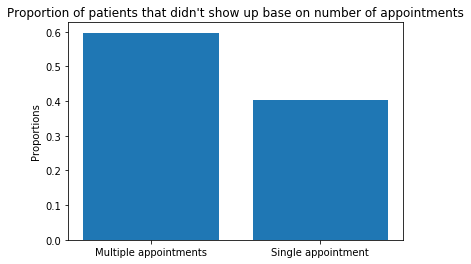

In [31]:
# plot bar chart of relative proportions of patients with a single appointment and those with more than one
# who didn't show up.

proportions = {'Single appointment': prop_one_app_no_show, 'Multiple appointments': prop_mul_app_no_show}
title = "Proportion of patients that didn't show up base on number of appointments"
plot_proportions(proportions, title) # plots the proportions on a bar chart.

Let's analyse the number of patients that didn't show up for each month base on whether they had a single or multiple appointments. Let's see how many months of appointment records were collected in 2016.

In [32]:
# number of appointments grouped by month

num_of_app_in_each_month = df.groupby(df.AppointmentDay.dt.month)['AppointmentID'].count()

num_of_app_in_each_month

AppointmentDay
4     3235
5    80841
6    26450
Name: AppointmentID, dtype: int64

Looks like we only have 3 months of data – April, May, and June. Let's get the number of patients with multiple appointments that didn't show up for each of these months.

In [33]:
# get unique patients with multiple appointments that didn't show up
# grouped by month
mul_app_no_show = df_mul_app.query(f"{no_show_up}")

unique_patients_with_mul_app = mul_app_no_show[mul_app_no_show['PatientId'].duplicated()==False]

mul_app_by_month = unique_patients_with_mul_app.groupby(
    unique_patients_with_mul_app.AppointmentDay.dt.month)['AppointmentID'].count()

Let's get those for patients with single appointments.

In [34]:
# get unique patients with one appointment that didn't show up
# grouped by month

one_app_no_show = df_one_app.query(f"{no_show_up}")

one_app_by_month = one_app_no_show.groupby(one_app_no_show.AppointmentDay.dt.month)['AppointmentID'].count()

Let's visualize the patient count for each month in both cases.

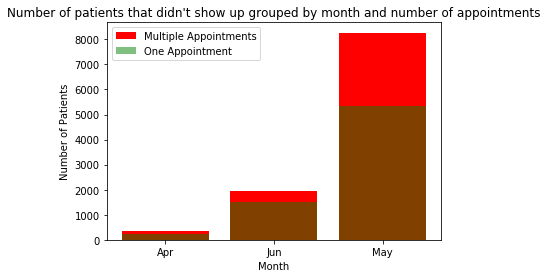

In [35]:
# plot the data for each category of patients

months = ['Apr', 'May', 'Jun']
title="Number of patients that didn't show up grouped by month and number of appointments"
x_label="Month"
y_label="Number of Patients"
legend_labels=["Multiple Appointments", "One Appointment"]
plot_2d_bar_chart(months, mul_app_by_month, one_app_by_month, title, x_label, y_label, legend_labels)

It looks like, for each month, there are more patients with multiple appointments that didn't show up. From our findings, **patients with multiple appointments are less likely to show up than those with a single appointment**. They probably rescheduled their appointments for another date which might be why they have multiple appointments recorded in the data set. It is also possible that the appointments where with two different doctors.

### Are patients less likely to show up if they don't suffer from any of the following cases: hypertension, diabetes, alcohol related problems, or a disability?

To answer this question, we will find the total number of unique patients that didn't show up and compare the proportion of those that suffer from any of these cases with those that don't. We will also compare the number of patients that fall in each of these categories in each month. The total number of unique patients that didn't show up is already stored in the no_show variable.

In [36]:
# this query string will help us retrieve patients that don't suffer from any of the cases

negative = '((Hypertension == 0) and \
             (Diabetes==0) and \
             (Alcoholism==0) and \
             (Handcap==0))'

# get patients that don't suffer from any of these cases and didn't show up

non_sufferer_no_show = df.query(f'{negative} and \
                        ({no_show_up})').PatientId.unique()

# get patients that suffer from any of these cases and didn't show up

sufferer_no_show = df.query(f'(not {negative}) and \
                     ({no_show_up})').PatientId.unique()

In [37]:
print(f'number of sufferers {sufferer_no_show.shape[0]}')
print(f'number of non-sufferers {non_sufferer_no_show.shape[0]}')

number of sufferers 3724
number of non-sufferers 13939


There seem to be more patients that don't suffer from any of these cases than those that do. Let's find their proportions.

In [38]:
# find the proportion of patients that suffer from these cases and those that don't but didn't show up

prop_sufferer_no_show = sufferer_no_show.shape[0]/no_show.shape[0]
prop_non_sufferer_no_show = non_sufferer_no_show.shape[0]/no_show.shape[0]

print(f"Proportion of patients that suffer from these cases: {prop_sufferer_no_show}")
print(f"Proportion of patients that don't suffer from these cases: {prop_non_sufferer_no_show}")

Proportion of patients that suffer from these cases: 0.2108362112891355
Proportion of patients that don't suffer from these cases: 0.7891637887108646


About 21% of the patients that didn't show up suffer from one of these cases while about 79% of them don't. Let's visualize this in a bar chart.

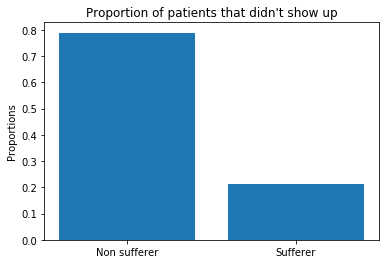

In [39]:
# plot relative proportion of patients that don't show up based on whether they suffer from any of the
# health challenges or not.

proportions = {'Sufferer': prop_sufferer_no_show, 'Non sufferer': prop_non_sufferer_no_show}
title="Proportion of patients that didn't show up"

plot_proportions(proportions, title)

Let's analyse the number of patients that didn't show up for each month base on whether they suffer from any of the health conditions or not. Let's first get the unique patients that didn't show up from our data set.

In [40]:
# get unique patients that didn't show up from the entire data set.

unique_patients_no_show = df.query(f"{no_show_up}")
unique_patients_no_show = unique_patients_no_show[unique_patients_no_show['PatientId'].duplicated()==False]

Now, let's get the number patients that suffer from any of the health conditions for each month.

In [41]:
# get number of patients with any of the health conditions for each month
sufferer = unique_patients_no_show.query(f'not ({negative})')
sufferer_by_month = sufferer.groupby(sufferer.AppointmentDay.dt.month)['AppointmentID'].count()

In [42]:
# get number of patients without any of the health conditions for each month

non_sufferer = unique_patients_no_show.query(f'({negative})')
non_sufferer_by_month = non_sufferer.groupby(non_sufferer.AppointmentDay.dt.month)['AppointmentID'].count()

Let's compare the counts for each month in a plot.

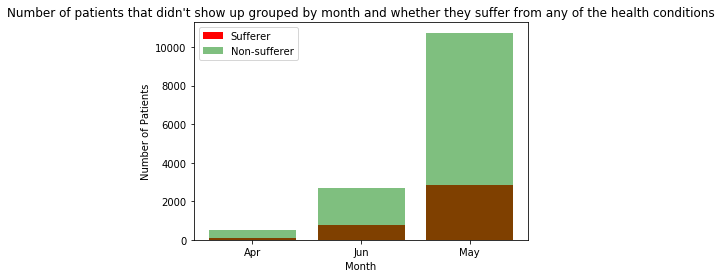

In [43]:
# plot the data for each category of patients

title="Number of patients that didn't show up grouped by month and whether they suffer from any of the health conditions"
x_label="Month"
y_label="Number of Patients"
legend_labels=["Sufferer", "Non-sufferer"]
plot_2d_bar_chart(months, sufferer_by_month, non_sufferer_by_month, title, x_label, y_label, legend_labels)

It looks like the trend is that **patients who do not suffer from any of the health conditions are less likely to show up for their appointments.**

### Are patients less likely to show up if they have a scholarship and suffer from any of the following cases: hypertension, diabetes, alcohol related problems, or a disability?

To answer this question, we will compare the proportion of patients who suffer from any of these cases and have a scholarship with that of patients who suffer from any of these cases without one. We will also compare the number of patients that fall in each of these categories in each month. The total number of patients that suffer from these cases and didn't show up is stored in the variable sufferer_no_show from our previous analysis. The variable negative will also come in handy for constructing our queries.

In [44]:
# get patients with scholarship and those without one.

has_scholarship = '(Scholarship == 1)'

scholarship = df.query('(not {0}) and {1} and \
                     (No_show == 1)'.format(negative, has_scholarship)).PatientId.unique()
no_scholarship = df.query('(not {0}) and (not {1}) and \
                     (No_show == 1)'.format(negative, has_scholarship)).PatientId.unique()

In [45]:
# proportion of patients with scholarship and those without one.

prop_with_scholarship = scholarship.shape[0]/sufferer_no_show.shape[0]
prop_without_scholarship = no_scholarship.shape[0]/sufferer_no_show.shape[0]
print(f"Proportion of patients with scholarship: {prop_with_scholarship}")
print(f"Proportion of patients without one: {prop_without_scholarship}")

Proportion of patients with scholarship: 0.109828141783029
Proportion of patients without one: 0.890171858216971


About 11% of the patients that suffer from any of the health problems and have a scholarship didn't show up, but 89% of those without a scholarship didn't show up.

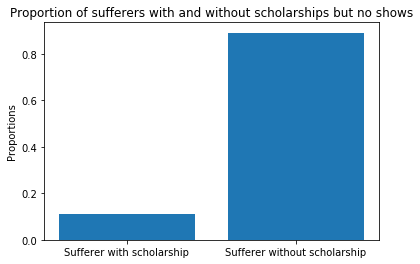

In [46]:
# plot the proportion of patients with scholarship and those without

proportions = {'Sufferer with scholarship': prop_with_scholarship, 
               'Sufferer without scholarship': prop_without_scholarship}
title = "Proportion of sufferers with and without scholarships but no shows"

plot_proportions(proportions, title)

Let's analyse the number of patients that didn't show up for each month if they suffer from any of the health conditions and have a scholarship. The sufferer variable already stores unique records of patients that suffer from any of the conditions but didn't show up.

In [47]:
# get number of sufferers with scholarship for each month

sufferer_with_scholarship = sufferer.query(f'{has_scholarship}')
num_with_scholarship_per_month = sufferer_with_scholarship.groupby(
    sufferer_with_scholarship.AppointmentDay.dt.month)['AppointmentID'].count()

In [48]:
# get number of sufferers without a scholarship for each month

sufferer_without_scholarship = sufferer.query(f'not {has_scholarship}')
num_without_scholarship_per_month = sufferer_without_scholarship.groupby(
    sufferer_without_scholarship.AppointmentDay.dt.month)['AppointmentID'].count()

Let's compare the counts for both cases in a plot.

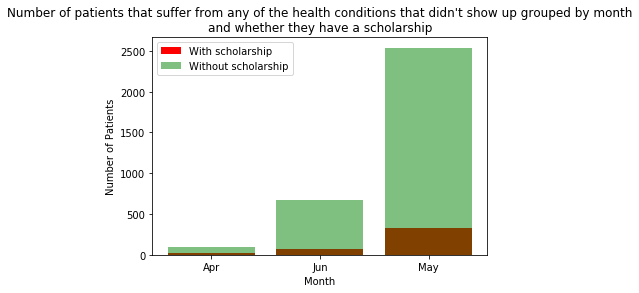

In [49]:
# plot the data for each category of patients

title="""Number of patients that suffer from any of the health conditions that didn't show up grouped by month
and whether they have a scholarship"""
x_label="Month"
y_label="Number of Patients"
legend_labels=["With scholarship", "Without scholarship"]
plot_2d_bar_chart(months, num_with_scholarship_per_month,
                  num_without_scholarship_per_month, title, x_label, y_label, legend_labels)

It looks like there is also a trend that **patients that suffer from any of the health conditions without a scholarship are less likely to show up for their appointments.**

### Are patients less likely to show up if they receive an SMS?

To answer this question, we will compare the proportion of patients that received an SMS but didn't show up with those that did not receive one and didn't show up. We will also compare the number of patients that fall in each of these categories in each month.

In [50]:
# get patients that didn't show up but received an sms and those that didn't
pos_sms_condition = 'SMS_received==1'
neg_sms_condition = 'SMS_received==0'

received_sms_no_show = unique_patients_no_show.query(f'({pos_sms_condition})')
received_no_sms_no_show = unique_patients_no_show.query(f'({neg_sms_condition})')

In [51]:
# compute their proportions
total = received_sms_no_show.shape[0] + received_no_sms_no_show.shape[0]

prop_received_sms = received_sms_no_show.shape[0]/total
prop_received_no_sms = received_no_sms_no_show.shape[0]/total

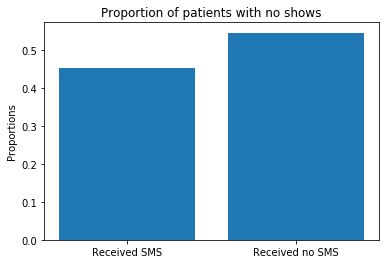

In [52]:
# plot their proportions on a bar chart

proportions = {'Received SMS': prop_received_sms, 
               'Received no SMS': prop_received_no_sms}
title = "Proportion of patients with no shows"

plot_proportions(proportions, title)

Next, let's analyse the number of patients that didn't show up for each month base on whether they received an SMS or not.

In [53]:
# get number of patients that received sms but didn't show up for each month

received_sms = unique_patients_no_show.query(f"{pos_sms_condition}")
num_received_sms_per_month = received_sms.groupby(received_sms.AppointmentDay.dt.month)['AppointmentID'].count()

In [54]:
# get number of patients that didn't receive an sms and didn't show up for each month

received_no_sms = unique_patients_no_show.query(f"{neg_sms_condition}")
num_received_no_sms_per_month = received_no_sms.groupby(received_no_sms.AppointmentDay.dt.month)['AppointmentID'].count()

Let's compare both data in a plot.

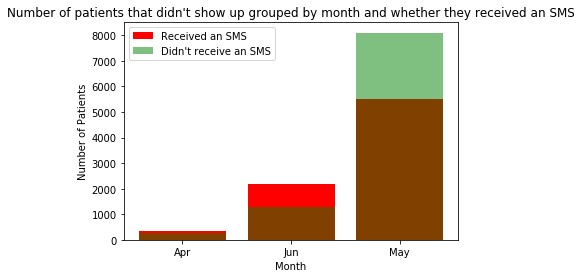

In [55]:
# plot the data for each category of patients

title="""Number of patients that didn't show up grouped by month and whether they received an SMS"""
x_label="Month"
y_label="Number of Patients"
legend_labels=["Received an SMS", "Didn't receive an SMS"]
plot_2d_bar_chart(months, num_received_sms_per_month,
                  num_received_no_sms_per_month, title, x_label, y_label, legend_labels)

It looks like patients who received an SMS didn't show up more in April and June. There seem to be no trend here. So, **we can't conclude that patients that didn't receive an SMS are less likely to show up compared to those that did.**

### Are male patients less likely to show up than female patients?

To answer this question, we will compare the proportion of male and female patients that didn't show up. We will also compare the number of patients that fall in each of these categories in each month.

In [56]:
# get male and female patients that didn't show up

males_no_show = df.query('(Gender=="M") and (No_show==1)').PatientId.unique()
females_no_show = df.query('(Gender=="F") and (No_show==1)').PatientId.unique()

In [57]:
# compute their relative proportions

prop_males_no_show = males_no_show.shape[0]/no_show.shape[0]
prop_females_no_show = females_no_show.shape[0]/no_show.shape[0]

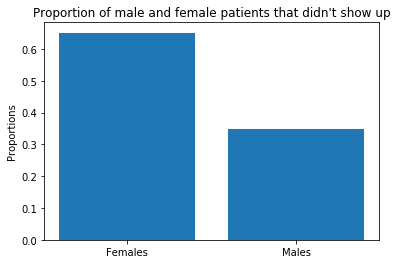

In [58]:
# plot their proportions on a bar chart

proportions = {'Males': prop_males_no_show, 
               'Females': prop_females_no_show}
title = "Proportion of male and female patients that didn't show up"

plot_proportions(proportions, title)

Now, let's analyse the number of patients that didn't show up for each month base on whether their gender.

In [59]:
# get number of male patients that didn't show up for each month.

males = unique_patients_no_show.query("Gender=='M'")
num_males_per_month = males.groupby(males.AppointmentDay.dt.month)['AppointmentID'].count()

In [60]:
# get number of male patients that didn't show up for each month.

females = unique_patients_no_show.query("Gender=='F'")
num_females_per_month = females.groupby(females.AppointmentDay.dt.month)['AppointmentID'].count()

Let's compare the data for both patient categories in a plot.

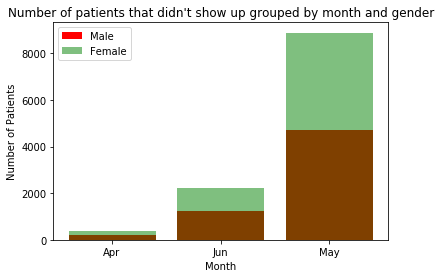

In [61]:
# plot the data for each category of patients

title="""Number of patients that didn't show up grouped by month and gender"""
x_label="Month"
y_label="Number of Patients"
legend_labels=["Male", "Female"]
plot_2d_bar_chart(months, num_males_per_month,
                  num_females_per_month, title, x_label, y_label, legend_labels)

It looks like there is a trend that **female patients are less likely to show up.**

### Are patients less likely to show up if their appointment is on the same day it was scheduled?

To answer this question, we will compare the proportion of patients whose appointment was on the same day it was scheduled and those whose appointment was on a different day. We will also compare the number of patients that fall in each of these categories in each month.

In [62]:
# patients whose appointment fell on the same day it was scheduled
same_date = df.ScheduledDay.dt.date == df.AppointmentDay.dt.date
appointments_on_same_day = df[same_date]

# patients whoe appointment fell on a different day
diff_date = df.ScheduledDay.dt.date < df.AppointmentDay.dt.date
appointments_on_diff_day = df[diff_date]

In [63]:
# compute the total number of patients whose appointment fell on the same day it was scheduled
# and those that fell on a different day but didn't show up.

diff_day_no_shows = appointments_on_diff_day.query("No_show == 1").PatientId.unique()
same_day_no_shows = appointments_on_same_day.query("No_show == 1").PatientId.unique()

total = diff_day_no_shows.shape[0] + same_day_no_shows.shape[0]

In [64]:
# compute the relative proportion of patients whose appointment fell on the same day it was scheduled
# and those that fell on a different day but didn't show up.

prop_diff_day_no_show = diff_day_no_shows.shape[0]/total
prop_same_day_no_shows = same_day_no_shows.shape[0]/total

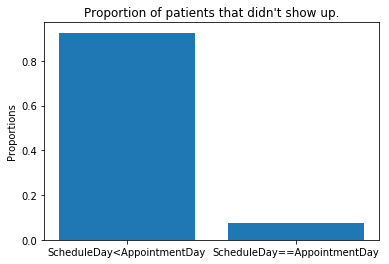

In [65]:
# visualize their proportions

proportions = {'ScheduleDay<AppointmentDay': prop_diff_day_no_show, 
               'ScheduleDay==AppointmentDay': prop_same_day_no_shows}
title="Proportion of patients that didn't show up."

plot_proportions(proportions, title)

Now, let's analyse the number of patients that didn't show up for each month base on whether their appointment fell on the same day it was scheduled. First, we will get these categories of patients from the unique_patients_no_show data frame.

In [66]:
# patients whose appointment fell on the same day it was scheduled
same_date = unique_patients_no_show.ScheduledDay.dt.date == unique_patients_no_show.AppointmentDay.dt.date
appointments_on_same_day = unique_patients_no_show[same_date]

# patients whose appointment fell on a different day
diff_date = unique_patients_no_show.ScheduledDay.dt.date < unique_patients_no_show.AppointmentDay.dt.date
appointments_on_diff_day = unique_patients_no_show[diff_date]

Now, let's find the number of patients that fall into these categories for each month.

In [67]:
# number of patients whose appointment was on the same day it was scheduled for each month

same_day_appointment_by_month= appointments_on_same_day.groupby(
    appointments_on_same_day.AppointmentDay.dt.month)['AppointmentID'].count()
same_day_appointment_by_month

AppointmentDay
4     31
5    943
6    196
Name: AppointmentID, dtype: int64

In [68]:
# number of patients whose appointment was on a different day for each month

diff_day_appointment_by_month = appointments_on_diff_day.groupby(
    appointments_on_diff_day.AppointmentDay.dt.month)['AppointmentID'].count()
diff_day_appointment_by_month

AppointmentDay
4      569
5    12667
6     3255
Name: AppointmentID, dtype: int64

Let's compare the data for both patient categories in a plot.

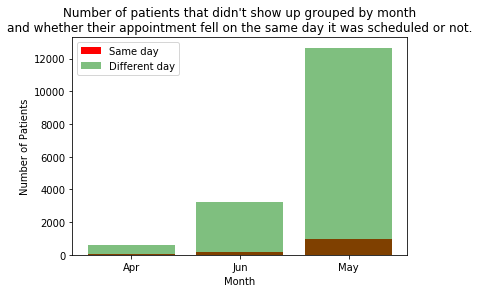

In [69]:
# plot the data for each category of patients

title="""Number of patients that didn't show up grouped by month
and whether their appointment fell on the same day it was scheduled or not."""
x_label="Month"
y_label="Number of Patients"
legend_labels=["Same day", "Different day"]
plot_2d_bar_chart(months, same_day_appointment_by_month,
                  diff_day_appointment_by_month, title, x_label, y_label, legend_labels)

It seems there is a trend that **patients whose appointment fell on a different day from the day it was scheduled are less likely to show up.**

###  Which of the age groups are less likely to show up?

First, let's create a data frame of unique patients.

In [70]:
df_unique_patients = df[df['PatientId'].duplicated()==False]
df_unique_patients.shape

(62298, 14)

In [71]:
# check if we have correctly gotten all the unique patients
df_unique_patients.shape[0] == df.PatientId.unique().shape[0]

True

Now, let's take a look at the histogram of the Age column.

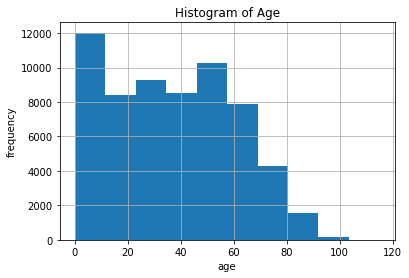

In [72]:
df_unique_patients["Age"].hist();
plt.title("Histogram of Age")
plt.xlabel("age")
plt.ylabel("frequency");

The distribution of the age of patients is skewed to the right with a mode of 0 years. This means that most of the patients are babies.

In [73]:
df_unique_patients['Age'].describe()

count    62298.000000
mean        36.705496
std         23.531076
min          0.000000
25%         17.000000
50%         36.000000
75%         56.000000
max        115.000000
Name: Age, dtype: float64

The summary statistics of the Age column shows that the mean age is about 37 years. Let's group the age of the patients into four categories: "Children", "Young Adults", "Middle-Aged", and "Older Adults".

In [74]:
# create a new column for age groups

bin_edges = [-1,19,36,56,116]
cat_labels = ['Children', 'Young Adults', 'Middle-Aged', 'Older Adults']
df_unique_patients['age_cat'] = pd.cut(df_unique_patients['Age'], bins=bin_edges, labels=cat_labels)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [75]:
df_unique_patients.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,age_cat
0,2.98724998243e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,Older Adults
1,5.58997776694e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,Middle-Aged
2,4.26296229995e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,Older Adults
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,Children
4,8.84118644818e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,Middle-Aged


We can now visualize the age group of the patients that didn't show up.

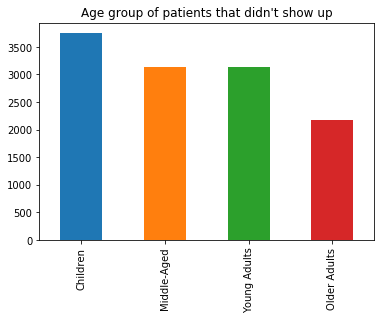

In [76]:
# age group of patients that didn't show up

noShows = df_unique_patients[df_unique_patients['No_show'] ==1]
ind = noShows['age_cat'].value_counts().index
noShows['age_cat'].value_counts()[ind].plot(kind='bar', title="Age group of patients that didn't show up");

Let's compare the number of patients that didn't show grouped by month and each age category in a plot to see if there might be a trend in which children are less likely to show up.

In [77]:
num_of_patients_each_month = noShows.groupby(['age_cat',noShows.AppointmentDay.dt.month])['AppointmentID'].count()
num_of_patients_each_month

age_cat       AppointmentDay
Children      4                  188
              5                 3058
              6                  509
Young Adults  4                  170
              5                 2553
              6                  404
Middle-Aged   4                  122
              5                 2568
              6                  438
Older Adults  4                   95
              5                 1719
              6                  369
Name: AppointmentID, dtype: int64

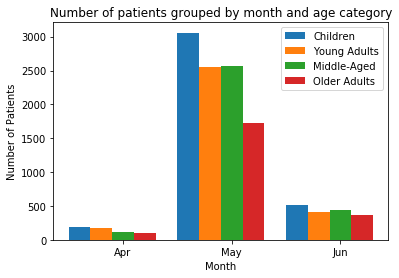

In [78]:
x_axis = np.arange(len(months))

plt.bar(x_axis-0.4,num_of_patients_each_month[cat_labels[0]], width=0.2, label=cat_labels[0])
plt.bar(x_axis-0.2, num_of_patients_each_month[cat_labels[1]], width=0.2, label=cat_labels[1])
plt.bar(x_axis, num_of_patients_each_month[cat_labels[2]], width=0.2, label=cat_labels[2])
plt.bar(x_axis+0.2, num_of_patients_each_month[cat_labels[3]], width=0.2, label=cat_labels[3])

plt.title('Number of patients grouped by month and age category')
plt.xticks(x_axis, months)
plt.xlabel('Month')
plt.ylabel('Number of Patients')
plt.legend();

From the above plot. It seems that there is indeed a trend. Therefore, we can conclude that **children are less likely to make their appointments while older adults are more likely to make theirs.** 

Note: I got how to make multi-bar charts from [GeeksforGeeks.](https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/)

<a id='conclusions'></a>
## Conclusions

Here is a summary of our findings:
- patients with multiple appointments are probably less likely to show up than those with a single appointment; 
- patients that don't suffer from any of the cases considered are probably less likely to show up for their appointments;
- patients are probably more likely to show up if they suffer from any of the health conditions but have a scholarship;
- we can't conclude that patients that didn't receive an SMS are less likely to show up compared to those that did because this only happened in the month of May;
- male patients are probably less likely to show up;
- patients are probably more likely to show up if their appointment fell on the same they that it was scheduled; and
- children are probably less likely to make their appointments while older adults are more likely to make theirs.

Therefore, the following factors might help us predict if a patient will likely not show up for their appointment: 
- if they have more than one appointment
- if they don't suffer from any case of hypertension, diabetes, alcohol related problems or disability;
- if they don't have a scholarship;
- if they are males;
- if their appointments don't fall on the same day it is scheduled; and
- if they are children;

The above findings are not conclusive and would still need to undergo statistical tests.

### Limitations

We would need to research further on why there are patients with multiple appointments. We are not sure if the appointments were made with more than one health practitioners or if they were appointments that were rescheduled. Furthermore, it is possible that patients may suffer from other health problems that might determine if they will or will not show up for their appointments which were not recorded in the data set. This is another area that requires further research.

In [84]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0